## Import Libraries

In [1]:
import pandas as pd
# check scikit-learn version
import sklearn
print(sklearn.__version__)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json
import time
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import PowerTransform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats.stats import pearsonr, spearmanr

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow
print(tensorflow.__version__)
# from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from collections import OrderedDict
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import mean_squared_error
from math import log
import tensorflow.keras.backend as K
from RegscorePy import *
print("GPU Available: ", tensorflow.test.is_gpu_available())



0.22.2.post1
2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using TensorFlow backend.


GPU Available:  True


## Helper Methods

In [2]:
def write_dict_to_json(path, content):
    with open(path + '.json', 'w') as file:
        file.write(json.dumps(content, ensure_ascii=False))
    
def write_str_to_txt(path, content):
    text_file = open(path + ".txt", "w")
    text_file.write(content) 
    text_file.close()

def plot_actual_vs_predicted(actual_column, predicted_column):
    plt.plot(list(range(1, len(actual_column) + 1)), actual_column, color='b', label='actual')
    plt.plot(list(range(1, len(actual_column) + 1)), predicted_column, color='r', label='predicted')
    plt.legend(loc='best')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted')
    plt.close()
    
def plot_actual_vs_predicted_scatter_bisector(actual_column, predicted_column):
    fig, ax = plt.subplots()
    ax.scatter(actual_column, predicted_column)
    ax.plot([actual_column.min(), actual_column.max()], [predicted_column.min(), predicted_column.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted_scatter_plot')
    plt.close()
    
    
def generate_lags_for(df, column, lags_count): 
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def error_metrics(y_test, y_pred, nb_columns, nb_param):
    n = len(y_test)
    #convert to float for it to work for AIC and BIC data should all be of the same format i.e float not mix of types
    y_test_f =  [float(item) for item in y_test.values]
    y_predict_f =  [float(item) for item in y_pred]
    test_scores = {}
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test_f, y_predict_f)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    re = (mse_score / np.mean(y_pred)) * 100
    accuracy = 100 - np.mean(mape_score)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    r2 = str(round(r2_Score, 2))
    adjusted_r2 = str(round(adjusted_r2, 2))
    mae = str(round(mae_score, 2))
    mse = str(round(mse_score, 2))
    rmse = str(round(rmse_score, 2))
    re = str(round(re, 2))
    spearman = str(round(spearman_corr, 2))
    mape = str(round(mape_score, 2)) + "%"
    accuracy = str(round(accuracy, 2)) + "%"
    
    nmi = 1
#     normalized_mutual_info_score(y_test_n, y_pred)
    
#     nmi = 0
#     inm = drv.information_mutual_normalised(y_test, y_pred)
#     array_sum = np.sum(inm)
#     inm_has_nan = np.isnan(array_sum)
#     if inm_has_nan:
#         nmi = "NaN"
#     else:
#         nmi = str(inm)


    def calculate_aic(n, mse, num_params):
        aic = n * log(mse) + 2 * num_params
        return aic

    def calculate_bic(n, mse, num_params):
        bic = n * log(mse) + num_params * log(n)
        return bic

    aic = str(round(calculate_aic(len(y_test), mse_score, nb_param), 2))
    bic = str(round(calculate_bic(len(y_test), mse_score, nb_param), 2))

    test_scores["average output"] =  str(y_test.mean())
    test_scores["R2"] = r2
    test_scores["Adjusted R2"] = adjusted_r2
    test_scores["MAE"] = mae
    test_scores["MSE"] = mse
    test_scores["RMSE"] = rmse
    test_scores["Relative Error"] = re
    test_scores["Spearman"] = spearman
    test_scores["MAPE"] = mape
    test_scores["Accuracy"] = accuracy
    test_scores["Information Mutal Normalised"] = nmi
    test_scores["AIC"] = aic
    test_scores["BIC"] = bic
    return test_scores

def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df

## Get the data

In [3]:
input_path = "gs://agriculture-sara/Data sets/Experiments/Experiment Details.xlsx"
output_path = "Daily Experiments/Base/Manual All/"
df_experiment = pd.read_excel(input_path, "Daily")
df_experiment

Name       Category Sub Category  \
0                  All Sites   Manual Bowen      Cleaned   
1            Ameriflux Sites   Manual Bowen      Cleaned   
2             Euroflux Sites   Manual Bowen      Cleaned   
3   Ameriflux Euroflux Sites   Manual Bowen      Cleaned   
4                  All Sites   Manual Bowen      Imputed   
5            Ameriflux Sites   Manual Bowen      Imputed   
6             Euroflux Sites   Manual Bowen      Imputed   
7   Ameriflux Euroflux Sites   Manual Bowen      Imputed   
8                  All Sites  Library Bowen      Cleaned   
9            Ameriflux Sites  Library Bowen      Cleaned   
10            Euroflux Sites  Library Bowen      Cleaned   
11                 All Sites    Library Ebr      Cleaned   
12           Ameriflux Sites    Library Ebr      Cleaned   
13            Euroflux Sites    Library Ebr      Cleaned   

                                          Description    Model name  
0   Trained and tested on all the sites with dropp...   All_M_Cl.h5  
1   Trained and tested on Ameriflux sites with dro...    Am_M_Cl.h5  
2   Trained and tested on Euroflux Sites with drop...    Ef_M_Cl.h5  
3   Trained on Ameriflux Sites and tested on Eurof...  AmEf_M_Cl.h5  
4   Trained and tested on all the sites with imput...   All_M_Im.h5  
5   Trained and tested on Ameriflux sites with imp...    Am_M_Im.h5  
6   Trained and tested on Euroflux Sites with impu...    Ef_M_Im.h5  
7   Trained on Ameriflux Sites and tested on Eurof...  AmEf_M_Im.h5  
8   Trained and tested on all the sites with dropp...  All_LB_Cl.h5  
9   Trained and tested on Ameriflux sites with dro...   Am_LB_Cl.h5  
10  Trained and tested on Euroflux Sites with drop...   Ef_LB_Cl.h5  
11  Trained and tested on all the sites with dropp...  All_LE_Cl.h5  
12  Trained and tested on Ameriflux sites with dro...   Am_LE_Cl.h5  
13  Trained and tested on Euroflux Sites with drop...   Ef_LE_Cl.h5

In [4]:
input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')


columnsToDrop = ['Site Id', 'Date','Year','Month','Day',
                 'Climate', 'Vegetation', 'Latitude', 'Longitude',
                 'G','G-1','G-2','G-3','G-4','G-5',
                 'Climate_1', 'Climate_2', 'Climate_3',
                 'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                 'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                 'Longitude_5', 'Longitude_6',
                 'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                 'H_bowen_corr-5', 'C_BOWENS',
                 'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                 'LE', 'LE_bowen_corr',
                 'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                 'Elevation(m)_5', 'Elevation(m)_6',
                 'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']


df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

output_column = "LE_bowen_corr(mm)"
df = df[df[output_column].between(1, 15)]
df.head()

Site Id_1  Site Id_2  Site Id_3  Site Id_4  Site Id_5  Site Id_6  Month_1  \
5          1          0          1          0          1          0        0   
6          1          0          1          0          1          0        0   
7          1          0          1          0          1          0        0   
8          1          0          1          0          1          0        0   
9          1          0          1          0          1          0        0   

   Month_2  Month_3  Month_4  ...  EEflux NDVI-2  EEflux NDVI-3  \
5        1        0        0  ...          0.402          0.413   
6        1        0        0  ...          0.453          0.402   
7        1        0        0  ...          0.481          0.453   
8        1        0        0  ...          0.449          0.481   
9        1        0        0  ...          0.363          0.449   

   EEflux NDVI-4  EEflux NDVI-5  EEflux Albedo  EEflux Albedo-1  \
5          0.316         -0.053          0.122            0.122   
6          0.413          0.316          0.122            0.122   
7          0.402          0.413          0.121            0.122   
8          0.453          0.402          0.121            0.121   
9          0.481          0.453          0.121            0.121   

   EEflux Albedo-2  EEflux Albedo-3  EEflux Albedo-4  EEflux Albedo-5  
5            0.121            0.121            0.110            0.507  
6            0.122            0.121            0.121            0.110  
7            0.122            0.122            0.121            0.121  
8            0.122            0.122            0.122            0.121  
9            0.121            0.122            0.122            0.122  

[5 rows x 50 columns]

In [5]:
lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
df = generate_lags(df, lagsForColumns)
print(df.columns)
print(df.shape)

num_features = df.shape[1]
print(num_features)

Index(['Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5',
       'Site Id_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr(mm)', 'EEflux LST',
       'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4',
       'EEflux LST-5', 'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2',
       'EEflux NDVI-3', 'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo',
       'EEflux Albedo-1', 'EEflux Albedo-2', 'EEflux Albedo-3',
       'EEflux Albedo-4', 'EEflux Albedo-5'],
      dtype='object')
(10916, 50)
50


In [6]:
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)

(10911, 50)


>svm -1.307 (0.034)
>knn -1.269 (0.035)
>cart -1.188 (0.040)


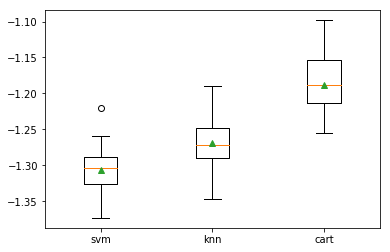

In [19]:
# make a prediction with a stacking ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X = df.drop([output_column], axis = 1)
Y = df[output_column]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>svm -1.307 (0.034)
>knn -1.269 (0.035)
>stacking -1.091 (0.033)
>cart -1.186 (0.038)


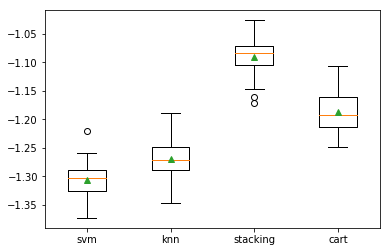

In [20]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('knn', KNeighborsRegressor()))
	level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('svm', SVR()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X = df.drop([output_column], axis = 1)
Y = df[output_column]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [21]:
# make a prediction with a stacking ensemble
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

# define dataset
X = df.drop([output_column], axis = 1)
Y = df[output_column]
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.1, random_state=42)

# define the base models
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('svm', SVR()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X_train, Y_train)

# make a prediction for one example
yhat = model.predict(X_test)

TypeError: only size-1 arrays can be converted to Python scalars

In [26]:
r2_Score = r2_score(Y_test, yhat)  # r-squared
rmse_score = np.sqrt(mean_squared_error(Y_test, yhat))  # RMSE
mse_score = mean_squared_error(Y_test, yhat)  # MSE
mae_score = mean_absolute_error(Y_test, yhat)  # MAE
mape_score = np.asarray(np.abs(( np.array(Y_test) - np.array(yhat)) / np.array(Y_test)), dtype=np.float64).mean() * 100  # MAP

print("r2:", r2_Score)
print("RMSE:", rmse_score)
print("MSE:", mse_score)
print("MAE:", mae_score)
print("MAPE:", mape_score)

r2: 0.4888161053495962
RMSE: 1.4956052743669637
MSE: 2.2368351367142805
MAE: 1.0692090133410272
MAPE: 34.862789110219836


In [27]:
# !pip install vecstack
# !pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=21047 sha256=2eddc96814623961f4f3aafd14226e764841dac9a5a7d72df0b6abd58c64c28d
  Stored in directory: /home/jupyter/.cache/pip/wheels/46/fa/89/f36db521d532b95b26e80cf62f51b49a06197cd3b7950f1c12
Successfully built vecstack
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
from vecstack import stacking
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

models = [
    KNeighborsRegressor(n_neighbors=5,
                        n_jobs=-1),
        
    RandomForestRegressor(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3)
]

X = df.drop([output_column], axis = 1)
Y = df[output_column]
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2, random_state=42)

S_train, S_test = stacking(models,                   
                           X_train, Y_train, X_test,   
                           regression=True, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=r2_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

task:         [regression]
metric:       [r2_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]
    fold  0:  [0.27750743]
    fold  1:  [0.30281451]
    fold  2:  [0.26238559]
    fold  3:  [0.22431506]
    fold  4:  [0.30121326]
    ----
    MEAN:     [0.27364717] + [0.02893443]
    FULL:     [0.27412698]

model  1:     [RandomForestRegressor]
    fold  0:  [0.41347517]
    fold  1:  [0.44179466]
    fold  2:  [0.42565580]
    fold  3:  [0.42917395]
    fold  4:  [0.43861864]
    ----
    MEAN:     [0.42974365] + [0.01005675]
    FULL:     [0.42998159]

model  2:     [XGBRegressor]
    fold  0:  [0.59127869]
    fold  1:  [0.61599277]
    fold  2:  [0.60541823]
    fold  3:  [0.60482687]
    fold  4:  [0.61662884]
    ----
    MEAN:     [0.60682908] + [0.00925011]
    FULL:     [0.60707893]



In [ ]:
def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mean_absolute_percentage_error'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    return model


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(S_train)
X_test_scaled = scaler.transform(S_test)

n_input = S_train.shape[1]
n_classes = 1
print("num of input:", n_input, "num of classes:", n_classes)

nb_columns = len(list(df.columns.values)) - 1


model = KerasRegressor(build_fn=create_model)


# Prepare the Grid
param_grid = {
              'first_neuron':[64],
              'activation' : ['softmax'],
              'init': ['uniform'],
              'dropout_rate' : [0.4],
              'dense_layer_sizes' : [2, 3],
              'optimizer' : ['Adam'],
              'loss': ['mean_absolute_percentage_error'],
              'epochs':[500],
              'batch_size':[64]
             }

best_params = param_grid
model = create_model(best_params["first_neuron"][0],
                    best_params["activation"][0],
                    best_params["init"][0],
                    best_params["dropout_rate"][0],
                    best_params["dense_layer_sizes"][0],
                    best_params["optimizer"][0],
                    best_params["loss"][0])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint(output_path + current_experiment["Model name"], monitor='val_mape', mode='min', verbose=1, save_best_only=True)
history = model.fit(X_train_scaled,
                    Y_train,
                    epochs=best_params["epochs"][0],
                   verbose=1,
                   callbacks=[mc, es])


In [ ]:
Y_predict = model.predict(S_test)
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
print("num parameters:", trainable_count)
num_parameters = trainable_count
test_scores = error_metrics(Y_test, Y_predict, num_features, num_parameters)
print(test_scores)

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e   